# MadMiner particle physics tutorial

# Part 1: Setup

Johann Brehmer, Felix Kling, Irina Espejo, and Kyle Cranmer 2018-2019

## 0. Preparations

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from madminer.core import MadMiner
from madminer.plotting import plot_2d_morphing_basis


In [3]:
# MadMiner output
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

## 1. Input data

As an example process to see how things work in Madminer, I'll simulate gg->H->4l process. My main objective is to try to measure the two EFT coefficients - cpG and ctp- that affect this process particularly strongly in the off-shell regime.



## 2. Define parameter space

There are two different ways I can approach the max morphing power, since it is not yet clear how strongly the quadratic terms will affect the low energy processes, and hence whether to include them along with dim-8 operators or with dim-6 ones. Anyway, for now though I am keeping morphing_max_power=2. We can discuss this in detail when the time comes. 

In [3]:
miner = MadMiner()

miner.add_parameter(
    lha_block='dim6',
    lha_id=8,
    parameter_name='cpG',
    morphing_max_power=2,
    parameter_range=(-10.,10.)
)

miner.add_parameter(
    lha_block='dim62f',
    lha_id=19,
    parameter_name='ctp',
    morphing_max_power=2,
    parameter_range=(-10.,10.)
)


02:42 madminer.core        INFO    Added parameter cpG (LHA: dim6 8, maximal power in squared ME: (2,), range: (-10.0, 10.0))
02:42 madminer.core        INFO    Added parameter ctp (LHA: dim62f 19, maximal power in squared ME: (2,), range: (-10.0, 10.0))


## 3. Define benchmarks (evaluation points for |M|^2) manually

The next step is the definition of all the points at which the weights (squared matrix elements) should be evaluated by MadGraph. We call these points "benchmarks". One can define benchmarks by hand:

In [4]:
miner.add_benchmark({'cpG':0., 'ctp':0.}, 'sm')
miner.add_benchmark({'cpG':5., 'ctp':0.}, 'w')
miner.add_benchmark({'cpG':-5., 'ctp':0.}, 'neg_w')
miner.add_benchmark({'cpG':0., 'ctp':5.}, 'ww')
miner.add_benchmark({'cpG':0., 'ctp':-5.}, 'neg_ww')

02:42 madminer.core        INFO    Added benchmark sm: ctp = 0.00e+00, cpG = 0.00e+00)
02:42 madminer.core        INFO    Added benchmark w: ctp = 0.00e+00, cpG = 5.00)
02:42 madminer.core        INFO    Added benchmark neg_w: ctp = 0.00e+00, cpG = -5.00e+00)
02:42 madminer.core        INFO    Added benchmark ww: ctp = 5.00, cpG = 0.00e+00)
02:42 madminer.core        INFO    Added benchmark neg_ww: ctp = -5.00e+00, cpG = 0.00e+00)


## 4. Morphing

Morphing is a powerful technique that allows for the fast and exact interpolation of event weights (or any derived quantity) from a set of original benchmark points (the "morphing basis") to anywhere in theory parameter space. This procedure depends on the powers with which the parameters affect the differential cross sections (this is why `add_parameter()` wants to know about this). Please see Sec. II.C.2 of ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020) for an explanation of the techniqe.

Morphing is not strictly necessary to run MadMiner, but it makes life easier in so many ways (and many methods are so far only implemented for morphing-based problems). We strongly recommend to use this wherever possible.

To activate morphing, the function `set_morphing` has to be called. With the option `include_existing_benchmarks=True`, MadMiner will keep all the benchmark points defined beforehand and run a simple optimization algorithm to fix the remaining ones for the basis (which may be none). Otherwise, MadMiner will optimize the full basis and forget about all previously defined benchmark points.

The other important keyword is `max_overall_power`. This sets the maximal combined power with which all parameters together contribute to the squared matrix element (cross section). This constraint is in addition to the `morphing_max_power` keyword of `add_parameter()` (see above). For instance, if there are two parameters of interest `a` and `b`, and it is known that there are contributions proportional to `1` (constant), `a`, `a^2`, `b`, `b^2`, and `ab`, then `max_overall_power=2`. If there are also contributions proportional to `a^2 b`, `a b^2`, and `a^2 b^2`, then `max_overall_power=4`.

In [5]:
miner.set_morphing(include_existing_benchmarks=True, max_overall_power=2)

02:42 madminer.core        INFO    Optimizing basis for morphing
02:42 madminer.core        INFO    Set up morphing with 2 parameters, 6 morphing components, 5 predefined basis points, and 1 new basis points


Let's have a look at the resulting morphing basis and the "morphing error", i.e. the sum of squared morphing weights as a function of the parameter space. The black dots mark the benchmarks at which the squared matrix element will be evaluated when MadGraph is run. In between them, the morphing will interpolate. Since the morphing knows about the functional form of the amplitudes, there is only a small numerical uncertainty in this interpolation, we expect that the color in this plot is indicative of this uncertainty.

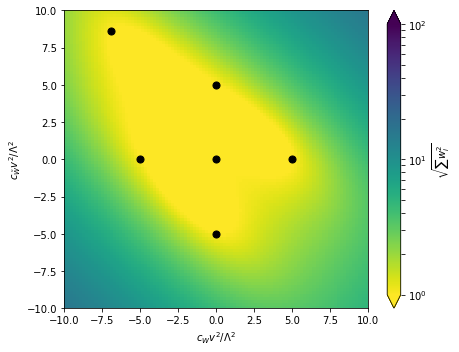

In [6]:
fig = plot_2d_morphing_basis(
    miner.morpher,
    xlabel=r'$c_{W} v^2 / \Lambda^2$',
    ylabel=r'$c_{\tilde{W}} v^2 / \Lambda^2$',
    xrange=(-10.,10.),
    yrange=(-10.,10.)
)

Note that squared weights (the colormap here) up to 1000 or even 10000 can still be perfectly fine and are in fact sometimes unavoidable.

## 5. Save setup

The parameter space, benchmark points, and morphing setup are saved in a HDF5 file:

In [7]:
miner.save('data/setup.h5')

02:42 madminer.core        INFO    Saving setup (including morphing) to data/setup.h5


They can now be loaded again with `miner.load(filename)`.

That's it for the setup (we'll only add one step when talking about systematic uncertainties in part 5 of the tutorial). Please continue with part 2a **or** part 2b, depending on whether you want to run the faster parton-level analysis or the more realistic Delphes-level analysis.